### ✅ **Step 1: Import Libraries and Load Dataset**

### Step 1: Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML + Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Display settings
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

### Step 2 : Loading the dataset

In [3]:
df = pd.read_csv('salary_data.csv')

In [4]:
# Displays first 5 rows of the dataset
df.head()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
0,32.0,Male,Bachelor's,Software Engineer,5.0,90000.0
1,28.0,Female,Master's,Data Analyst,3.0,65000.0
2,45.0,Male,PhD,Senior Manager,15.0,150000.0
3,36.0,Female,Bachelor's,Sales Associate,7.0,60000.0
4,52.0,Male,Master's,Director,20.0,200000.0


In [5]:
# Displays last 5 rows of the dataset
df.tail()

,Age,Gender,Education Level,Job Title,Years of Experience,Salary
6699,49.0,Female,PhD,Director of Marketing,20.0,200000.0
6700,32.0,Male,High School,Sales Associate,3.0,50000.0
6701,30.0,Female,Bachelor's Degree,Financial Manager,4.0,55000.0
6702,46.0,Male,Master's Degree,Marketing Manager,14.0,140000.0
6703,26.0,Female,High School,Sales Executive,1.0,35000.0


### ✅ **Step 2: Basic EDA (Exploratory Data Analysis)**

In [6]:
# Basic info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB


In [7]:
# Summary statistics
df.describe()

,Age,Years of Experience,Salary
count,6702.000000,6701.000000,6699.000000
mean,33.620859,8.094687,115326.964771
std,7.614633,6.059003,52786.183911
min,21.000000,0.000000,350.000000
25%,28.000000,3.000000,70000.000000
50%,32.000000,7.000000,115000.000000
75%,38.000000,12.000000,160000.000000
max,62.000000,34.000000,250000.000000


In [8]:
# Check for missing values
df.isnull().sum()

Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64

In [9]:
# Fill missing values in numerical columns
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Years of Experience'].fillna(df['Years of Experience'].median(), inplace=True)
df['Salary'].fillna(df['Salary'].median(), inplace=True)

# Fill missing values in categorical columns 
df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
df['Education Level'].fillna(df['Education Level'].mode()[0], inplace=True)
df['Job Title'].fillna(df['Job Title'].mode()[0], inplace=True)

In [10]:
print("Remaining missing values:")
print(df.isnull().sum())

Remaining missing values:
Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64


### Visualising the distributions

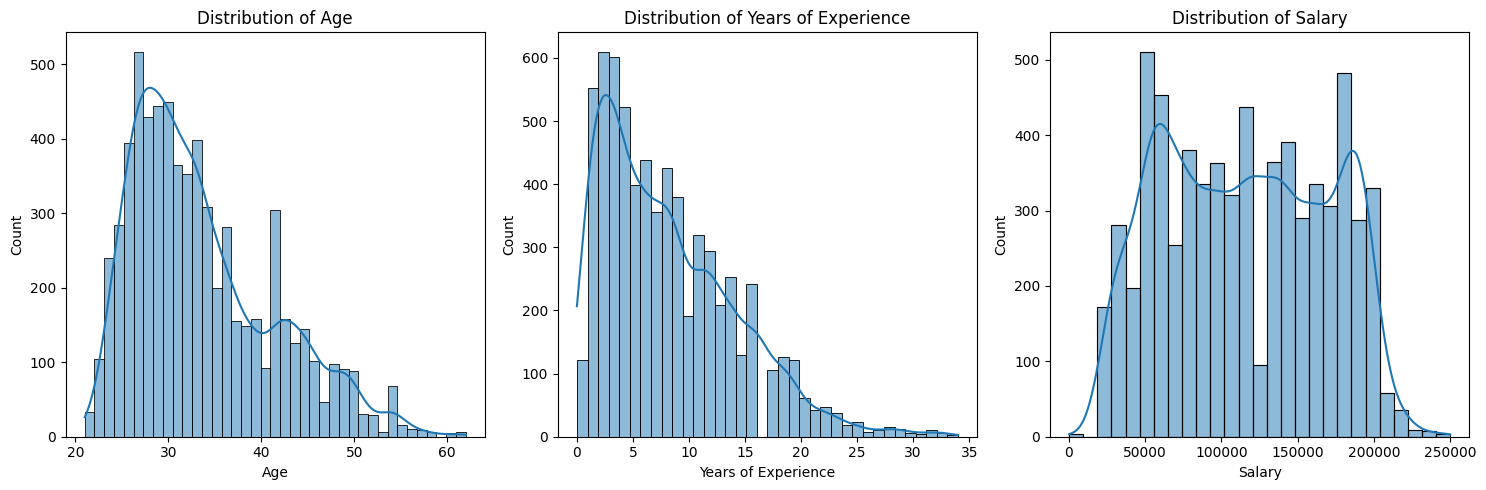

In [11]:
# Distribution of numerical features
num_cols = ['Age', 'Years of Experience', 'Salary']

plt.figure(figsize=(15, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [12]:
df['Education Level'] = df['Education Level'].replace('phD', 'PhD') # to remove inconsistencies

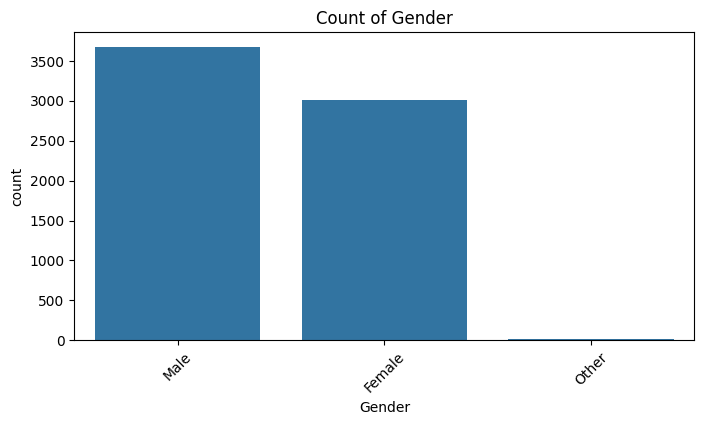

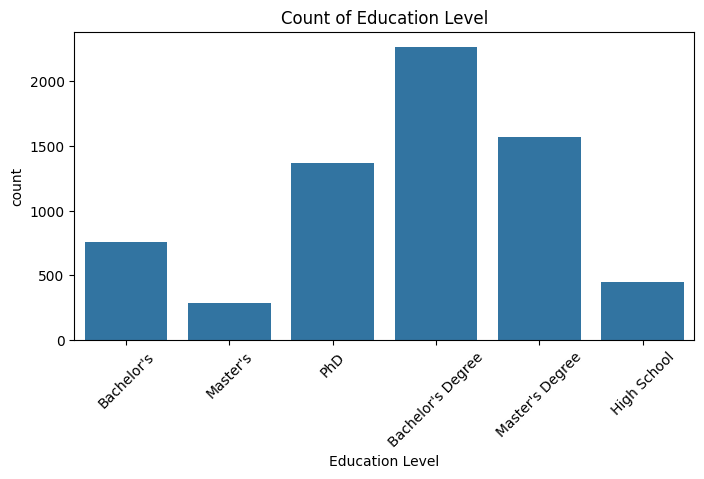

In [13]:
# Categorical feature counts
cat_cols = ['Gender', 'Education Level']
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)
    plt.show()

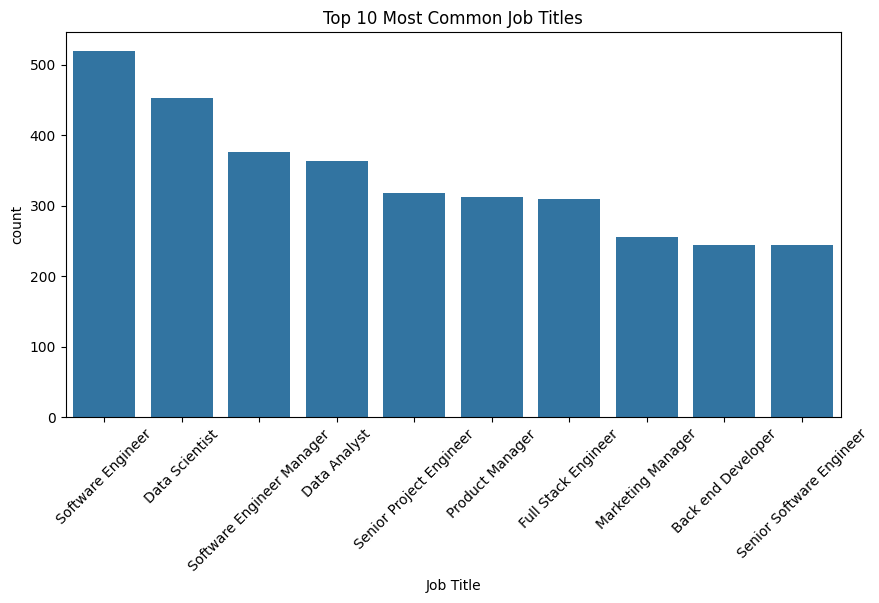

In [14]:
top_jobs = df['Job Title'].value_counts().nlargest(10).index
df_top_jobs = df[df['Job Title'].isin(top_jobs)]

plt.figure(figsize=(10, 5))
sns.countplot(x='Job Title', data=df_top_jobs, order=top_jobs)
plt.title('Top 10 Most Common Job Titles')
plt.xticks(rotation=45)
plt.show()

## ✅ **Step 3: Outlier Detection & Handling**

### We'll be identifying outliers in **numerical features** using both:

* **Visual methods** (boxplots)
* **Statistical methods** (IQR method)

### 🔍 **3.1 Boxplot Visualization (Visual Outlier Detection)**

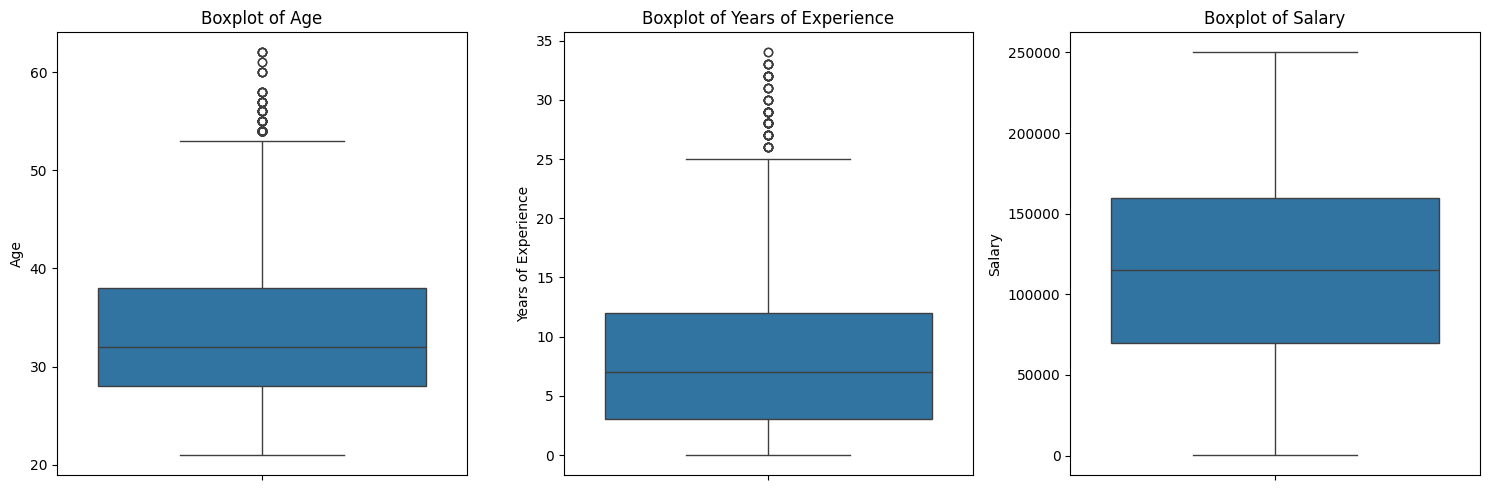

In [15]:
# This shows you where potential **outliers** are located beyond the "whiskers" of the box.
num_cols = ['Age', 'Years of Experience', 'Salary']

plt.figure(figsize=(15, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

### 🧮 **3.2 IQR Method (Remove Outliers Statistically)**

In [16]:
# Function to remove outliers
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [17]:
# Remove outliers for all numerical columns
# Removing outliers from numerical columns
# This will clean extreme values that could distort the model
df_cleaned = df.copy()
for col in ['Age', 'Years of Experience', 'Salary']:
    before = df_cleaned.shape[0]
    df_cleaned = remove_outliers_iqr(df_cleaned, col)
    after = df_cleaned.shape[0]
    print(f"{col}: Removed {before - after} outliers")

Age: Removed 123 outliers
Years of Experience: Removed 25 outliers
Salary: Removed 0 outliers


In [18]:
### Comparing Before vs After
print("Original dataset shape:", df.shape)
print("After outlier removal:", df_cleaned.shape)

Original dataset shape: (6704, 6)
After outlier removal: (6556, 6)


## ✅ **Step 5: Encoding Categorical Variables & Feature Scaling**

### This step includes:
1. 🔢 **Encoding categorical variables** (`Gender`, `Education Level`, `Job Title`)
2. 📏 **Feature scaling** (for numeric features if needed)

### Why Encoding?
Machine learning models **can’t work with text**, so we must convert categorical columns into numerical form.

### Why Scaling?
Many ML models (like SVM, KNN, Gradient Descent–based models) perform better when features are **on the same scale**.

### 5.1 Identify column types

In [19]:
categorical_cols = ['Gender', 'Education Level', 'Job Title']
numerical_cols = ['Age', 'Years of Experience']
target_col = 'Salary'

### 5.2 Use ColumnTransformer for Encoding + Scaling

We’ll apply:

* **OneHotEncoding** to categorical features
* **StandardScaler** to numerical features

In [20]:
# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
    ]
)

### 5.3 Apply Transformation to Data

In [21]:
# Splitting the data into `X` and `y` and applying the transformations

# Separate features and target
X = df_cleaned.drop('Salary', axis=1)
y = df_cleaned['Salary']

In [22]:
# Fit and transform
X_processed = preprocessor.fit_transform(X)

In [23]:
# At this point, `X_processed` is a fully numeric, scaled, and encoded version of our feature set — ready for machine learning.
# Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

## ✅ **Step 6: Training All ML Models & Comparing Performance**

### 6.1 Training the models 

In [24]:
# List of models to train
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror')
}

In [25]:
results = []
trained_models = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    trained_models[name] = model  # storing the trained models
    
    # Predict on train set
    y_train_pred = model.predict(X_train)
    # Predict on test set
    y_test_pred = model.predict(X_test)
    
    # Calculate train metrics
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate test metrics
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        "Model": name,
        "Train MAE": train_mae,
        "Train RMSE": train_rmse,
        "Train R2": train_r2,
        "Test MAE": test_mae,
        "Test RMSE": test_rmse,
        "Test R2": test_r2
    })

In [26]:
# Convert to DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Sort by Test RMSE or any metric you prefer
results_df = results_df.sort_values(by='Test RMSE')

print(results_df)

               Model     Train MAE    Train RMSE  Train R2      Test MAE  \
4      Random Forest   1506.640024   3608.223418  0.995214   2723.421985   
8            XGBoost   3962.013117   6055.119139  0.986523   4747.387782   
3      Decision Tree    859.965577   2724.658767  0.997271   2601.647251   
6                KNN   3202.504272   7928.432574  0.976894   4071.656098   
5  Gradient Boosting  10466.561679  13711.896200  0.930890  10574.211229   
2              Lasso  11933.779919  16822.226601  0.895981  11717.972700   
0  Linear Regression  11804.725835  16805.188417  0.896191  11675.497874   
1              Ridge  12356.549170  17080.529132  0.892762  12054.596457   
7                SVR  44753.767632  51909.628848  0.009528  44444.806086   

      Test RMSE   Test R2  
4   7113.418611  0.981124  
8   7820.377481  0.977185  
3   8470.907459  0.973232  
6   9095.794014  0.969137  
5  13906.848093  0.927853  
2  16760.063374  0.895211  
0  16809.447540  0.894593  
1  17034.302411

### 6.2 Plot Comparison Graph 

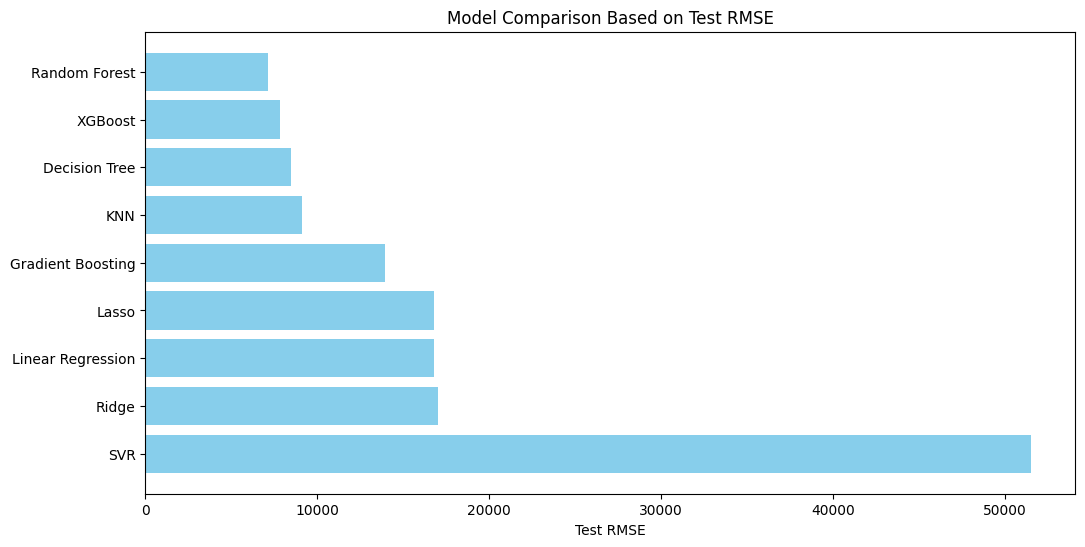

In [27]:
plt.figure(figsize=(12,6))
plt.barh(results_df['Model'], results_df['Test RMSE'], color='skyblue')
plt.xlabel('Test RMSE')
plt.title('Model Comparison Based on Test RMSE')
plt.gca().invert_yaxis()  # Best model on top
plt.show()

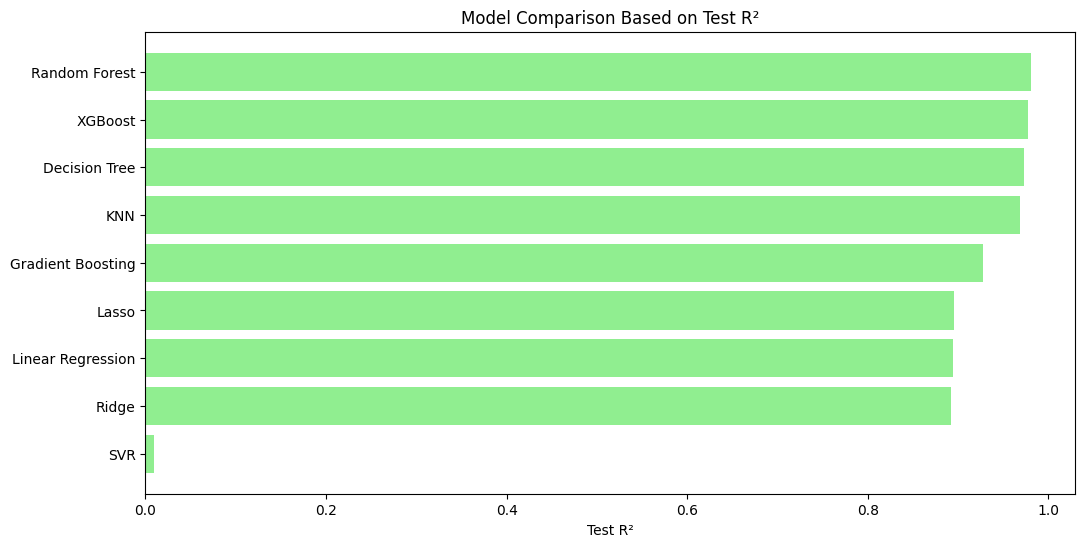

In [28]:
plt.figure(figsize=(12,6))
plt.barh(results_df['Model'], results_df['Test R2'], color='lightgreen')
plt.xlabel('Test R²')
plt.title('Model Comparison Based on Test R²')
plt.gca().invert_yaxis()  # Best model on top
plt.show()

### 6.3 Get Best Model Details (lowest RMSE)

In [29]:
best_model_name = results_df.iloc[0]['Model']
print(f"Best model is: {best_model_name}")

best_model = trained_models[best_model_name] 

Best model is: Random Forest


## ✅ **Step 7: Saving the Preprocessing Pipeline and the Best Model**

In [33]:
import joblib
import sklearn

# Print sklearn version for compatibility checking
print("scikit-learn version:", sklearn.__version__)

# Save the trained best model
joblib.dump(best_model, 'best_model.pkl')

# Save the fitted preprocessing pipeline
joblib.dump(preprocessor, 'preprocessor.pkl')

scikit-learn version: 1.6.1


['preprocessor.pkl']